In [248]:
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import rdFMCS, Descriptors, AllChem, rdmolops

In [767]:
def set_unspecified_bond(mol):
    for bond in mol.GetBonds():
        bond.SetBondType(Chem.BondType.UNSPECIFIED)
    return mol

def list_mols(reactant, product):
    return [Chem.MolFromSmiles(sm) for sm in (reactant, product)]

def create_reaction(reactant, product):
    mols_unspec_bond = [set_unspecified_bond(mol) for mol in list_mols(reactant, product)]
    mols = list_mols(reactant, product)
    for mol in mols:
        Chem.Kekulize(mol, True)
        Chem.SetAromaticity(mol, Chem.rdmolops.AromaticityModel.AROMATICITY_MDL)
    mcs = rdFMCS.FindMCS(mols_unspec_bond).queryMol
    matches = [mol.GetSubstructMatch(mcs) for mol in mols_unspec_bond]
    map_count = 1
    for atoms_idx in zip(*matches):
        for mol, idx in zip(mols, atoms_idx):
            atom = mol.GetAtomWithIdx(idx)
            atom.SetAtomMapNum(map_count)
        map_count +=1
    mols_smarts = [Chem.MolToSmarts(mol) for mol in mols]
    return AllChem.ReactionFromSmarts('>>'.join(mols_smarts))

In [768]:
smiles = "N1C=CC2=C1C=CC=C2"
smiles = "COCC=C1CN2CCC3=C4[C@@H]2C[C@@H]1[C@H](N4c1ccccc31)C(=O)OC"
#smiles = "C1=CC=C2NC3=C(C=CC=C3)C2=C1"
react = Chem.MolFromSmiles(smiles)
#react = Chem.AddHs(react)
products = rxn.RunReactant(react,0)
#products = [Chem.RemoveAllHs(product[0]) for product in products]
#products = [Chem.MolToSmiles(product) for product in products]
#products[0]
print(AllChem.ReactionToSmarts(rxn))
products

[#7&H1:1]1:[#6:2]:[#6:4]:[#6:5]2:[#6:3]:1:[#6:6]:[#6:8]:[#6:9]:[#6:7]:2>>[#8]-[#6:9]1:[#6:7]:[#6:5]2:[#6:3](:[#7&H1:1]:[#6:2]:[#6:4]:2):[#6:6]:[#6:8]:1


()

In [606]:
def list_mols_smarts(reactant, product):
    return [Chem.MolFromSmarts(sm) for sm in (reactant, product)]

def create_reaction_smarts(reactant, product):
    mols_unspec_bond = [set_unspecified_bond(mol) for mol in list_mols_smarts(reactant, product)]
    mols = list_mols_smarts(reactant, product)
    #return mols_unspec_bond
    mcs = rdFMCS.FindMCS(mols_unspec_bond).queryMol
    # return mcs
    matches = [mol.GetSubstructMatch(mcs) for mol in mols_unspec_bond]
    # return matches
    map_count = 1
    for atoms_idx in zip(*matches):
        for mol, idx in zip(mols, atoms_idx):
            atom = mol.GetAtomWithIdx(idx)
            atom.SetAtomMapNum(map_count)
        map_count +=1
    mols_smarts = [Chem.MolToSmarts(mol) for mol in mols]
    return AllChem.ReactionFromSmarts('>>'.join(mols_smarts))


In [714]:
def unset_mapping(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(0)
        if atom.GetAtomicNum() == 0:
            atom.SetAtomicNum(1)
    return mol

def remove_Hs(mol):
    if sum([atom.GetAtomicNum() == 1 for atom in mol.GetAtoms() ]) >1:
        return mol
    else:
        return Chem.RemoveAllHs(mol)

def format_react_smarts(raw_smarts):
    smarts = raw_smarts.split(">>")
    # smarts = [sm.replace("=,:", "=") for sm in smarts]
    mols = [Chem.MolFromSmarts(sm) for sm in smarts]
    mols = [remove_Hs(mol) for mol in mols]
    mols = [unset_mapping(mol) for mol in mols]
    for mol in mols:
        Chem.Kekulize(mol) 
    smarts = [Chem.MolToSmarts(mol) for mol in mols]
    return smarts

def react_from_raw_smarts(raw_smarts):
    return (create_reaction_smarts(*format_react_smarts(raw_smarts)))

def format_react_smiles(raw_smarts):
    smarts = raw_smarts.split(">>")
    smarts = [sm.replace("=,:", "=") for sm in smarts]
    mols = [Chem.MolFromSmarts(sm) for sm in smarts]
    mols = [remove_Hs(mol) for mol in mols]
    mols = [unset_mapping(mol) for mol in mols]
    for mol in mols:
        Chem.Kekulize(mol) 
    smarts = [Chem.MolToSmiles(mol) for mol in mols]
    return smarts

def react_from_raw_smiles(raw_smarts):
    return (create_reaction(*format_react_smiles(raw_smarts)))

In [800]:
data0 = ['[#6:1](=,:[#8:2])(-[#6:3])-[#6:4]>>[#6:4]-[#6:1](-[#8:2]-[H])(-[H])-[#6:3]',
 'CNC(C)C(=O)c1ccc(C)cc1',
 'CNC(C)C(O)c1ccc(C)cc1']

data0 = ['[#6:3]/[#6:1]=,:[#6:2]\\[#6:4]>>[#6:4]-[#6:2]1-[#8]-[#6:1]-1-[#6:3]',
 'C/C=C/C',
 'CC1OC1C']

def run_reaction(rxn, react):
    Chem.Kekulize(react, True)
    Chem.SetAromaticity(react, Chem.rdmolops.AromaticityModel.AROMATICITY_MDL)
    return rxn.RunReactant(react,0)

def eval_react_process(data):
    for method in [react_from_raw_smarts, react_from_raw_smiles]:
        try:
            rxn = method(data[0])
            react = Chem.MolFromSmiles(data[1])
            react = Chem.AddHs(react)
            products = run_reaction(rxn, react)
            products = [Chem.RemoveAllHs(product[0]) for product in products]
            products = [Chem.MolToSmiles(product) for product in products]
            for product in products:
                if product == Chem.MolToSmiles(Chem.MolFromSmiles(data[2])):
                    return (True,rxn)
        except:
            pass
    return (False, (rxn, products))
    #data_product = Chem.MolToSmiles(Chem.MolFromSmiles(data[2]))
    #prod_smiles = Chem.MolToSmiles(product)
    #return [rxn, prod_smiles, data_product]
    #test_smiles = smiles[0] == smiles[1]
    #return test_smiles, Chem.MolFromSmiles(".".join(smiles))

eval_react_process(data0)


(True, <rdkit.Chem.rdChemReactions.ChemicalReaction at 0x7f053c434f30>)

In [801]:
dataset0 = Path("../react_process.csv").read_text().split('\n')

def eval_dataset(dataset):
    nok = []
    for row in dataset:
        data = row.split("|")
        #print(data[0])
        try:
            test, res = eval_react_process(data[1:])
            if not test:
                print("NOK {}".format(data[0]))
                #print(res)
                nok.append((data, res))
                break
            else:
                 print("ok {}".format(data[0]))
        except Exception as ex:
            print( "ERROR {}".format(data[0]))
            return data
            #break
            #return 'ex'
    return nok
eval_dataset(dataset0)
#nok[0]

ok Methylated heteroatoms/Demethylation
NOK Oxydation of allylic methyle


RDKit ERROR: [17:57:06] Explicit valence for atom # 0 C, 5, is greater than permitted


[(['Oxydation of allylic methyle',
   '[#6:1]/[#6:3](=,:[#6:4](/[#6:5](-[H])(-[H])-[H])-[H])-[#6:2]>>[#6:1]/[#6:3](=,:[#6:4](/[#6:5](-[#8])(-[H])-[H])-[H])-[#6:2]',
   'C/C=C1/CN2[C@H]3C[C@@H]1[C@@H](C(=O)O)[C@@H]2CC1=C3Nc2ccc(OC)cc21',
   'COc1ccc2c(c1)C1=C(N2)[C@@H]2C[C@H]3C(=CCO)CN2[C@@H](C1)[C@@H]3C(=O)O'],
  (<rdkit.Chem.rdChemReactions.ChemicalReaction at 0x7f053c4243a0>,
   ((<rdkit.Chem.rdchem.Mol at 0x7f053c31dbd0>,),
    (<rdkit.Chem.rdchem.Mol at 0x7f053c31d7b0>,))))]

In [802]:
Chem.MolToSmiles(Chem.MolFromSmiles('COc1ccc2c(c1)C1=C(N2)[C@@H]2C[C@H]3C(=CCO)CN2[C@@H](C1)[C@@H]3C(=O)O'))

'COc1ccc2[nH]c3c(c2c1)C[C@H]1[C@H](C(=O)O)[C@H]2C[C@@H]3N1CC2=CCO'

In [803]:
smarts = '[#6:1]/[#6:3](=,:[#6:4](/[#6:5](-[H])(-[H])-[H])-[H])-[#6:2]>>[#6:1]/[#6:3](=,:[#6:4](/[#6:5](-[#8])(-[H])-[H])-[H])-[#6:2]'
mols = format_react_smarts(smarts)
rxn = create_reaction_smarts(*mols)

react = Chem.MolFromSmiles('COCC=C1CN2CC[C@]34C(=C(C(=O)OC)[C@H]1C[C@H]23)Nc1ccccc14')
react = Chem.AddHs(react)
run_reaction

IndexError: tuple index out of range

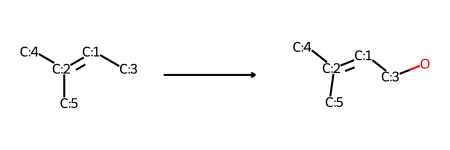

In [799]:
#smarts = "[#7:2]1/[#6:9]=,:[#6:8]\\[#6:7]2:[#6:3]-1:[#6:4]:[#6:5]:[#6:1](:[#6:6]:2)-[H:10]>>[#8:10]-[#6:1]1:[#6:6]:[#6:7]2:[#6:3](-[#7:2]/[#6:9]=,:[#6:8]\\2):[#6:4]:[#6:5]:1"
rxn = react_from_raw_smiles(smarts)
rxn

1


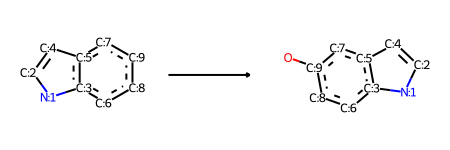

In [778]:
rxn = create_reaction("N1C=CC2=C1C=CC=C2", "OC1=CC2=C(NC=C2)C=C1")
react = Chem.MolFromSmiles(smiles)
#react = Chem.AddHs(react)
Chem.Kekulize(react, True)
Chem.SetAromaticity(react, Chem.rdmolops.AromaticityModel.AROMATICITY_MDL)
print(len(rxn.RunReactant(react,0)))
AllChem.
rxn

In [765]:
r_smarts = "[#7:2]1/[#6:9]=,:[#6:8]\[#6:7]2:[#6:3]-1:[#6:4]:[#6:5]:[#6:1](:[#6:6]:2)-[H:10]>>[#8:10]-[#6:1]1:[#6:6]:[#6:7]2:[#6:3](-[#7:2]/[#6:9]=,:[#6:8]\2):[#6:4]:[#6:5]:1"
r_smarts = '[#7:2]1/[#6:9]=,:[#6:8]\\[#6:7]2:[#6:3]-1:[#6:4]:[#6:5]:[#6:1](:[#6:6]:2)-[H:10]>>[#8:10]-[#6:1]1:[#6:6]:[#6:7]2:[#6:3](-[#7:2]/[#6:9]=,:[#6:8]\\2):[#6:4]:[#6:5]:1'
r_smarts = r_smarts.replace("\\", "-").replace("/", "-")
rxn = Chem.rdChemReactions.ReactionFromSmarts(r_smarts)
react = Chem.MolFromSmiles(smiles)
react = Chem.AddHs(react)
Chem.Kekulize(react, True)
Chem.SetAromaticity(react, Chem.rdmolops.AromaticityModel.AROMATICITY_MDL)
rxn.RunReactant(react,0)

((<rdkit.Chem.rdchem.Mol at 0x7f053c3a7c90>,),)

In [531]:
eval_react_process([
  '[#6:1]-[N,O,S:2]-[#6](-[H])(-[H])-[H]>>[#6:1]-[#0:2]',
  'COCC=C1CN2CC[C@]34C(=C(C(=O)OC)[C@H]1C[C@H]23)Nc1ccccc14',
  'COC(=O)C1=C2Nc3ccccc3[C@@]23CCN2CC(=CCO)[C@@H]1C[C@H]23'])

 'COCC=C1CN2CC[C@]34C(=C(C(=O)OC)[C@H]1C[C@H]23)Nc1ccccc14',
 'COC(=O)C1=C2Nc3ccccc3[C@@]23CCN2CC(=CCO)[C@@H]1C[C@H]23']

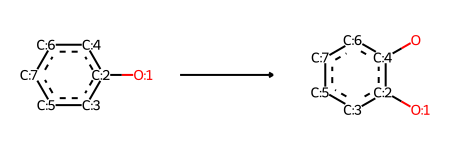

In [358]:
error_smarts = "[#6:1]1(:[#6:2](:[#6:3](:[#6:4]:[#6:5](:[#6:6]:1-[H:7])-[!O:8])-[!O:9])-[H:10])-[#8:11]>>[#6:1]1(:[#6:2](:[#6:3](:[#6:4]:[#6:5](:[#6:6]:1-[#8:7])-[*:8])-[*:9])-[H:10])-[#8:11]"
rxn = react_from_raw_smarts(error_smarts)
rxn
#rxn.RunReactants((pz,))[0][0]

In [341]:
format_react_smarts(error_smarts)

['*c1cc(O)cc(*)c1', '*c1cc(*)c(O)c(O)c1']

['AddConformer', 'ClearComputedProps', 'ClearProp', 'Compute2DCoords', 'ComputeGasteigerCharges', 'Debug', 'GetAromaticAtoms', 'GetAtomWithIdx', 'GetAtoms', 'GetAtomsMatchingQuery', 'GetBondBetweenAtoms', 'GetBondWithIdx', 'GetBonds', 'GetBoolProp', 'GetConformer', 'GetConformers', 'GetDoubleProp', 'GetIntProp', 'GetNumAtoms', 'GetNumBonds', 'GetNumConformers', 'GetNumHeavyAtoms', 'GetProp', 'GetPropNames', 'GetPropsAsDict', 'GetRingInfo', 'GetStereoGroups', 'GetSubstructMatch', 'GetSubstructMatches', 'GetUnsignedProp', 'HasProp', 'HasSubstructMatch', 'NeedsUpdatePropertyCache', 'RemoveAllConformers', 'RemoveConformer', 'SetBoolProp', 'SetDoubleProp', 'SetIntProp', 'SetProp', 'SetUnsignedProp', 'ToBinary', 'UpdatePropertyCache', '__DebugMol', '__GetSubstructMatch', '__GetSubstructMatches', '__class__', '__copy__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getinitargs__', '__gt__', '__hash__', '__init__', '_

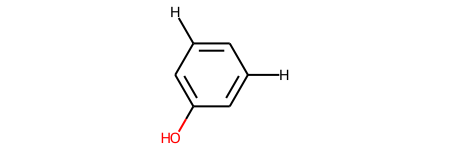

In [354]:
mol = Chem.MolFromSmiles('*c1cc(O)cc(*)c1')
#to_remove
for atom in mol.GetAtoms():
    if atom.GetAtomicNum() == 0:
        print(atom.GetIdx())
        atom.SetAtomicNum(1)
#mw = Chem.RWMol(m)
mol

[#8:1]-[#6:2]1:[#6:3]:[#6:5]:[#6:7]:[#6:6]:[#6:4]:1>>[#8:1]-[#6:2]1:[#6:3](-[#17]):[#6:5]:[#6:7]:[#6:6]:[#6:4]:1


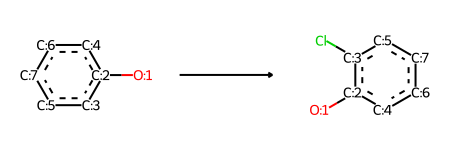

In [302]:
rxn = create_reaction("Oc1ccccc1", "Oc1c(Cl)cccc1")
print(AllChem.ReactionToSmarts(rxn))
pz = Chem.MolFromSmiles("COc1ccc(/C=C/N2C(=O)/C(=C\CCNC(=N)N)N=C2O)cc1Br")
rxn.RunReactants((pz,))[0][0]
rxn

In [288]:
errors[1][1]

 'COc1ccc(/C=C/N2C(=O)/C(=C\\CCNC(=N)N)N=C2O)cc1(Br)I',
 'COc1c(Br)cc(/C=C/N2C(=O)/C(=C\\CCNC(=N)N)N=C2O)cc1I']

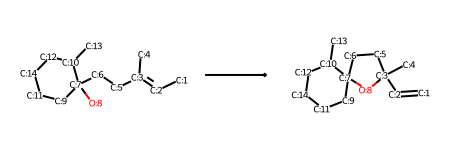

In [533]:

react = Chem.AddHs(react)
#r_smarts = raw_smarts.replace("\\", "-").replace("/", "-")
raw_rxn = Chem.rdChemReactions.ReactionFromSmarts(r_smarts)
raw_rxn.RunReactant(react,0)[0]
# raw_rxn
#react

(<rdkit.Chem.rdchem.Mol at 0x7f053c5085d0>,)

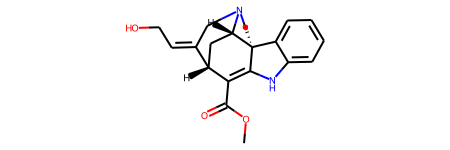

In [435]:
Chem.MolFromSmiles('COC(=O)C1=C2Nc3ccccc3[C@@]23CCN2CC(=CCO)[C@@H]1C[C@H]23')

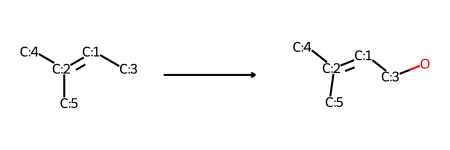

In [124]:
smarts = "[#6:1]/[#6:3](=,:[#6:4](/[#6:5](-[H])(-[H])-[H])-[H])-[#6:2]>>[#6:1]/[#6:3](=,:[#6:4](/[#6:5](-[#8])(-[H])-[H])-[H])-[#6:2]"
mols = format_react_smarts(smarts)
create_reaction(*mols)

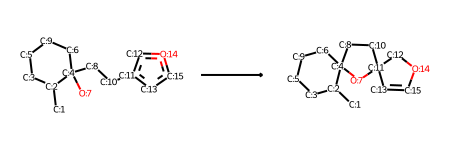

In [122]:
smarts = "[#6:1]1(-[#6:2](-[#6:3]-[#6:4]-[#6:5]-[#6:6]-1)-[#6:7])(-[#6:8]-[#6:9]-[#6:10]1/[#6]=,:[#6]\[#8]/[#6]=,:1)-[#8:11]>>[#6:1]12(-[#6:2](-[#6:3]-[#6:4]-[#6:5]-[#6:6]-1)-[#6:7])-[#6:8]-[#6:9]-[#6:10]1(/[#6]=,:[#6]\[#8]-[#6]-1)-[#8:11]-2"
mols = format_react_smarts(smarts)
create_reaction(*mols)

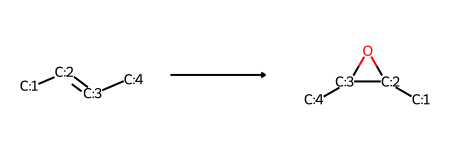

In [77]:
sm_react = "C\C=C\C"
sm_prod = "CC1OC1C"
rxn = create_reaction(sm_react, sm_prod)
rxn


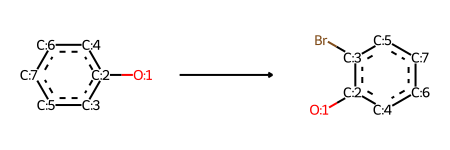

In [61]:
rxn = create_reaction("Oc1ccccc1", "Oc1c(Br)cccc1")
rxn

In [ ]:
rxn = create_reaction("Oc1ccccc1", "Oc1c(Br)cccc1")
pz = Chem.MolFromSmiles("[H]\C(=C(\[H])C1=CC=C(O)C=C1)N1C(O)=NC(CCCNC(N)=N)C1=O")
res = rxn.RunReactants((pz,))[0][0]

In [63]:
Chem.MolToSmiles(res)

'N=C(N)NCCCC1N=C(O)N(/C=C/c2ccc(O)c(Br)c2)C1=O'

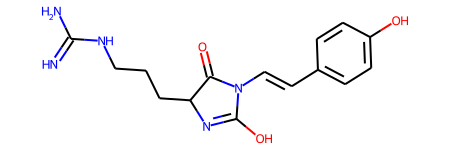

In [64]:
pz

In [27]:
Chem.Kekulize(res, clearAromaticFlags=True)
Chem.MolToSmiles(res, kekuleSmiles=True, isomericSmiles=False)

'N=C(N)NCCCC1N=C(O)N(C=CC2=CC(Br)=C(O)C=C2)C1=O'

In [26]:
"NC(=N)NCCCC1NC(=O)N(C=CC2=CC=C(O)C(Br)=C2)C1=O"

'NC(=N)NCCCC1NC(=O)N(C=CC2=CC=C(O)C(Br)=C2)C1=O'

In [9]:
Chem.MolToSmiles(rxn.RunReactants((pz,))[0][0], kekuleSmiles=True)

'N=C(N)NCCCC1N=C(O)N(/C=C/C2:C:C:C(O):C(Br):C:2)C1=O'

In [10]:
Chem.MolToSmiles(rxn.RunReactants((pz,))[0][0], kekuleSmiles=False)

'N=C(N)NCCCC1N=C(O)N(/C=C/c2ccc(O)c(Br)c2)C1=O'

'NC(=N)NCCCC1NC(=O)N(C=CC2=CC=C(O)C(Br)=C2)C1=O'

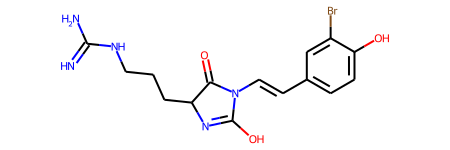

In [8]:
Chem.MolFromSmiles("[H]\C(=C(\[H])c1ccc(O)c(Br)c1)N1C(O)=NC(CCCNC(N)=N)C1=O")

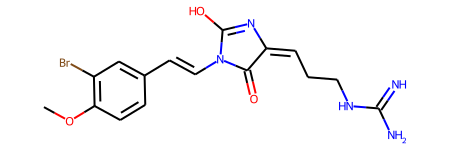

In [97]:
pz = Chem.MolFromSmiles("[H]\C(CCNC(N)=N)=C1/N=C(O)N(\C([H])=C(/[H])C2=CC=C(OC)C=C2)C1=O")
pz
rxn.RunReactants((pz,))[0][0]

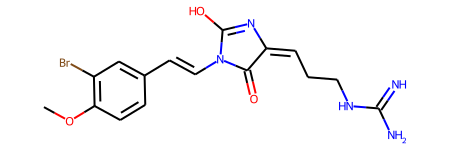

In [98]:
rxn.RunReactants((pz,))[1][0]

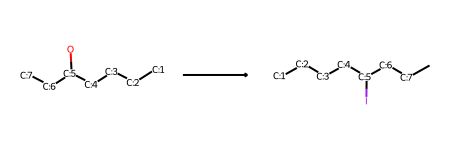

In [65]:
create_reaction("CCCCC(O)CC", "CCCCC(I)CCC")

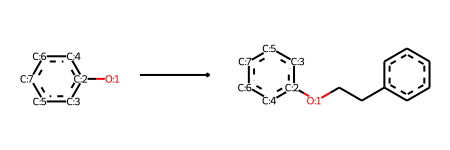

In [66]:
create_reaction("OC1=CC=CC=C1", "C(CC1=CC=CC=C1)OC1=CC=CC=C1")

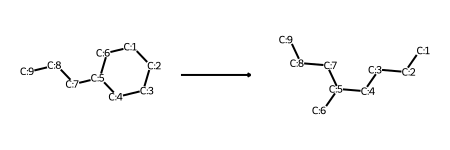

In [67]:
rxn = create_reaction("CCCC1CCCCC1", "CCCCC(C)CCC")
rxn

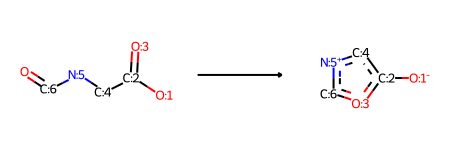

In [68]:
rxn = create_reaction("OC(=O)CNC=O", "[O-]C1=C[NH+]=CO1")
rxn

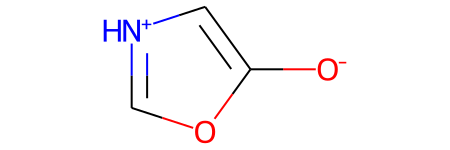

In [69]:
pz = Chem.MolFromSmiles("OC(=O)CNC=O")
pz
rxn.RunReactants((pz,))[0][0]

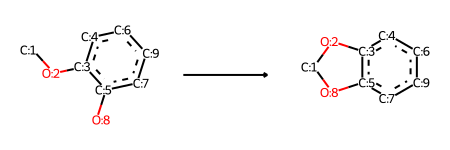

In [70]:
sm_react = "COC1=CC=CC=C1O"
sm_prod = "C1OC2=C(O1)C=CC=C2"
rxn = create_reaction(sm_react, sm_prod)
rxn

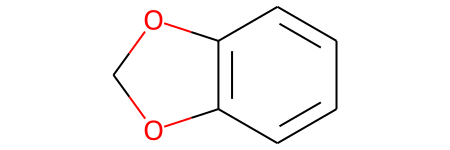

In [9]:
prod = Chem.MolFromSmiles(sm_react)
rxn.RunReactants((prod,))[0][0]

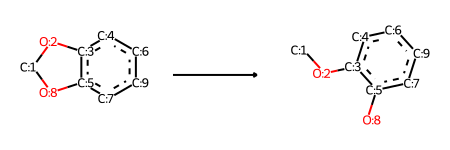

In [71]:
sm_react = "C1OC2=C(O1)C=CC=C2"
sm_prod = "COC1=CC=CC=C1O"
rxn = create_reaction(sm_react, sm_prod)
rxn

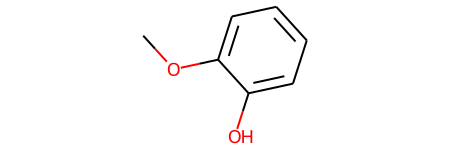

In [72]:
prod = Chem.MolFromSmiles(sm_react)
rxn.RunReactants((prod,))[0][0]

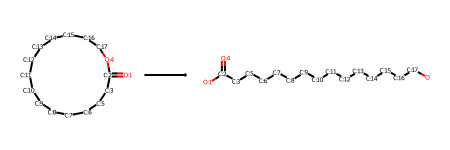

In [73]:
sm_react = "O=C1CCCCCCCCCCCCCCO1"
sm_prod = "OCCCCCCCCCCCCCCC(O)=O"
rxn = create_reaction(sm_react, sm_prod)
rxn

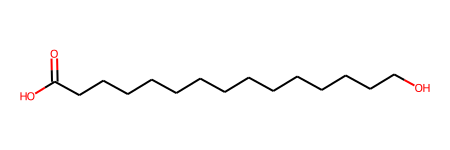

In [74]:
prod = Chem.MolFromSmiles(sm_react)
rxn.RunReactants((prod,))[0][0]

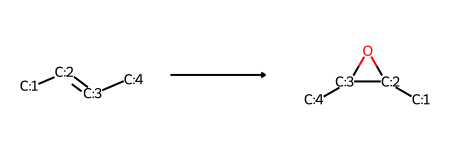

In [100]:
sm_react = "C\C=C\C"
sm_prod = "CC1OC1C"
rxn = create_reaction(sm_react, sm_prod)
rxn
#Chem.MolFromSmiles(sm_react)

In [98]:
react = Chem.MolFromSmiles("C1=CC=CC=C1")
rxn.RunReactants((react,))[0][0]
#print(Chem.MolToSmiles(react))
#react

IndexError: tuple index out of range

In [78]:
#dir(Chem.BondType)

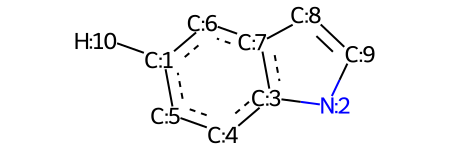

In [689]:
smarts = "[#7:2]1/[#6:9]=[#6:8]\[#6:7]2:[#6:3]-1:[#6:4]:[#6:5]:[#6:1](:[#6:6]:2)-[H:10]"
mol = Chem.MolFromSmarts(smarts)
mol

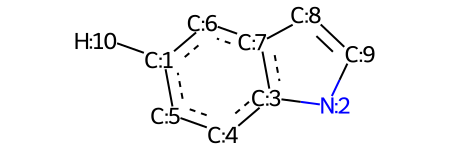

In [690]:
Chem.Kekulize(mol, clearAromaticFlags=True)
mol

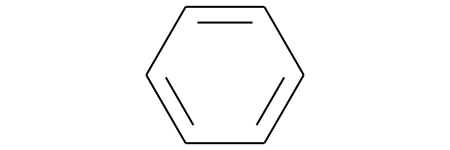

In [693]:
mol = Chem.MolFromSmiles("c1ccccc1")
mol

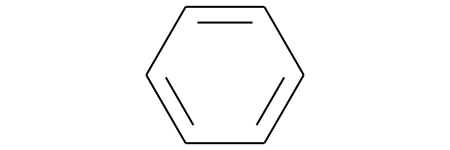

In [695]:
Chem.Kekulize(mol, clearAromaticFlags=False)
mol